# Discount Analysis

## Hypothesis Statement

### Set up churn probability threshold

Pull out the data from the random forest model with predicted churn probability. Use the top 10% probability (0.29) as the churn probability threshold because overally nearly 10% clients churn in the whole dataset. Clients with a probability to churn higher than 0.29 would be considered to churn in the future.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./sample_data_with_predictions.csv')
df_extra = pd.read_csv('./clean_data_after_eda.csv')
df.drop(["Unnamed: 0"],inplace=True,axis=1)
np.percentile(df["churn_probability"], 90)

0.20899999999999999

### Design Discount - Churn Function

If PowerCo issues discount to clients, their chances to churn will be reduced. Let's suppose the outcome we want to study follows a function with discount as an independent variable, which satisfies:

- The outcome should be the probability the client would continue to reduce their probability of churn, for example, if the outcome for one client is 80%, and the client is already predicted by the random forest model to churn at a probability of 30%, then the new probability of this client to churn is 30%*80% = 24%
- When discount = 0, the outcome should be 1
- Suppose that the maximum PowerCo can offer is 60%; and the outcome can't be reduced to 0, suppose the minimum outcome should be 20%
- The curve of the function would be S-shape, because when the discount rate is small, say at 0-15%, it's not attracting enough to retain customers; and when it's large enough, say at 45-60%, the clients would become indifferent to it, their probablity to churn won't reduce much anyway, which is a diminishing marginal effect.

So we construct a sigmoid funtion that contains the points (0,1) and (0.6, 0.2):

$$outcome=\frac{1}{e^{\beta*discount+\alpha}+1}+\frac{1}{\gamma}$$
where:

- $\gamma$ >5, for convinience we set it at 10
- $\alpha$'s value depend on $\gamma$, the pair moves in opposite directions. When $\gamma$ is set to 10, $\alpha$ must be set at $-ln9$, namely -2.197
- $\beta$ controls the slope of the S-curve, larger $\beta$ means flatter slope; but since $\gamma$ and $\alpha$ are set, the value of $\beta$ can only set to be $\frac{10}{3}ln9$, namely 7.324

According to all above, we are temporarily using the function
$$outcome=\frac{1}{e^{7.324*discount-2.197}+1}+\frac{1}{10}$$

The churn rate is reduced from 10.22% to 4.22% as the 20% discount is issued.

In [2]:
# Calculate the outcome and reassign churn_probability
discount = 0.2
outcome = 1/(np.exp(7.324*discount-2.197)+1)+0.1
print(outcome)
# df["corrected"]

# Correcting the result of churn according to the new threshold
threshold = 0.208
df["churn"] = df["churn_probability"].apply(lambda x:1 if x>=threshold else 0)
df["churn_after_discount"] = df["churn_probability"].apply(lambda x:1 if x*outcome>=threshold else 0)
mean_churn = np.mean(df["churn"])
mean_churn_discount = np.mean(df["churn_after_discount"])
print(f"The average churn rate is {mean_churn}")
print(f"The average churn rate after applying discount is {mean_churn_discount}")

0.775287861654
The average churn rate is 0.10223642172523961
The average churn rate after applying discount is 0.04221816522136011


### Revenue Loss for Churning Clients

The predicted result `churn` defines whether client is going to churn in Jan-Mar 2016, but it doesn't specifys what the exact time point the client will churn. If the client churns at Jan/01/2016, PowerCo will lose 100% of the profit on it; if it churns at Feb/03/2016, PowerCo will lose 1-33/365=90.959% profit. In average, we suppose the revenue loss on churning clients is 1-(60/2)/365=91.78%.

The result of 20% discount is not ideal for accumulating profit. So we should look like the how profit is changing through discount.

In [3]:
# df = df.merge(df_extra["forecast_cons_12m"], left_index=True, right_index=True)
df["base_revenue"] = (np.power(10,df["forecast_cons_12m"])+1)*df["forecast_price_energy_off_peak"]+df["forecast_meter_rent_12m"]

# Taking churn into account
df["base_revenue_after_churn"] = df["base_revenue"]*(1-0.919*df["churn"])
df["base_revenue_after_churn_discount"] = (1-discount)*df["base_revenue"]*(1-0.919*df["churn_after_discount"])
revenue_o_discount = df["base_revenue_after_churn"].sum()
revenue_i_discount = df["base_revenue_after_churn_discount"].sum()
print(f"The total revenue without discount is {revenue_o_discount}")
print(f"The average churn rate after applying discount is {revenue_i_discount}")

The total revenue without discount is 986917.7420630485
The average churn rate after applying discount is 842708.9412674203


## Tuning Parameters for the Discount-Churn Function and Finding the perfect discount rate

### Revenue-Discount plot

Stay with the primitive Discount-Churn function with $\gamma=10$, and draw the revenue-discount plot. We can see that under this circumstance, as discount rate grows, both churn rate and revenue goes down linearly, meaning that under such a discount-churn function pattern, any discount will kill the profit, so discount is useless in increasing profit(but somewhat useful in retaining clients).

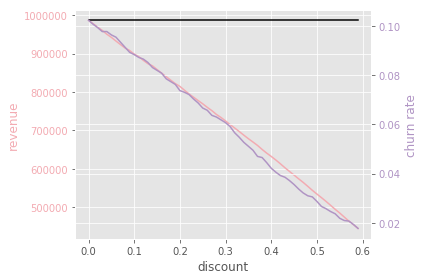

In [4]:
def discount_revenue(df,discount,gamma):
    # Calculate alpha and beta based on gamma
    alpha = -np.log(gamma-1)
    beta = 5/3*(np.log((4*gamma+5)/(gamma-5)))
    outcome = 1/(np.exp(beta*discount+alpha)+1)+1/gamma
    # Calculate revenue
    df["churn_discount"] = df["churn_probability"].apply(lambda x:1 if x*outcome>=threshold else 0)
    df["base_revenue_after_churn_discount"] = (1-discount)*df["base_revenue"]* \
    (1-0.919*df["churn_discount"])
    mean_churn = np.mean(df["churn_discount"])
    total_revenue = df["base_revenue_after_churn_discount"].sum()
    return mean_churn,total_revenue

discount_list = [i for i in np.arange(0,0.6,0.01)]
revenue_list = [discount_revenue(df,i,10)[1] for i in discount_list]
churn_list = [discount_revenue(df,i,10)[0] for i in discount_list]
# fig,
plt.style.use("ggplot")
ax1 = plt.gca()

ax1.set_xlabel('discount')
ax1.set_ylabel('revenue', color='#F3ABB2')
ax1.plot(discount_list, revenue_list, color='#F3ABB2')
ax1.plot(discount_list, [revenue_o_discount for i in discount_list], color='black')
ax1.tick_params(axis='y', labelcolor='#F3ABB2')

ax2 = ax1.twinx() 
ax2.set_ylabel('churn rate', color='#B094C4') 
ax2.plot(discount_list, churn_list, color='#B094C4')
ax2.tick_params(axis='y', labelcolor='#B094C4')

plt.tight_layout()
plt.show()

### Outcome-Discount Plot

Therefore, we suppose the discount-churn function we use is inproper. A proper gamma value should fix this problem and lift the revenue above the baseline revenue wothout any discount. 

We start digging into this problem be changing gamma and find the pattern of the outcome-discount function. From the plot below, we can see that the loser to 5 the gamma value is, the outcome falls faster, which means small amount of change in discount rate will result in more clients to stay. When gamma is higher than 6, the fall in outcome would become slow so discount will not play a significant part in retain clients.

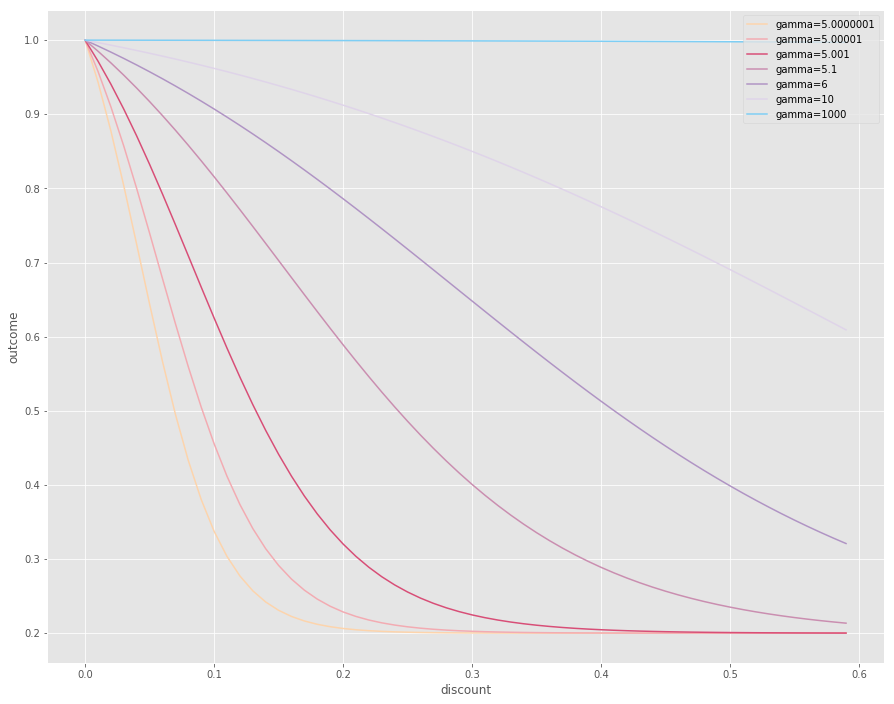

In [5]:
def outcome_discount(gamma,discount_list):
    alpha = -np.log(gamma-1)
    beta = 5/3*(np.log((4*gamma+5)/(gamma-5)))
    outcome = 1/(np.exp(beta*discount+alpha)+1)+1/gamma
    return [1/(np.exp(beta*i+alpha)+1)+1/gamma for i in discount_list]
    
c_list = ['#FDD4AC', '#F3ABB2', '#D84E77', '#CA8EB0', '#B094C4', '#DFD4E9', '#7ECEF4']
discount_list = [i for i in np.arange(0,0.6,0.01)]
fig,axs = plt.subplots(figsize=(15,12))
axs.plot(discount_list,outcome_discount(5.0000001,discount_list),color=c_list[0],
         label="gamma=5.0000001")
axs.plot(discount_list,outcome_discount(5.00001,discount_list),color=c_list[1],label="gamma=5.00001")
axs.plot(discount_list,outcome_discount(5.001,discount_list),color=c_list[2],label="gamma=5.001")
axs.plot(discount_list,outcome_discount(5.1,discount_list),color=c_list[3],label="gamma=5.1")
axs.plot(discount_list,outcome_discount(6,discount_list),color=c_list[4],label="gamma=6")
axs.plot(discount_list,outcome_discount(10,discount_list),color=c_list[5],label="gamma=10")
axs.plot(discount_list,outcome_discount(1000,discount_list),color=c_list[6],label="gamma=1000")
# axs.plot(discount_list,outcome_discount(100000,discount_list),color=c_list[2],label="gamma=100000")
plt.xlabel("discount")
plt.ylabel("outcome")
plt.legend(loc="upper right")
plt.show()

### Revenue-Gamma Plot

Only gamma = 5.0000001, gamma = 5.00001 and gamma=5.001 can beat the revenue without discount. The highest revenue are achieved with discount under 10% by all three gamma values. Also, smaller gamma must get clients much less likely to churn with a under 10%'s dicount, which is sometimes very hard to be the real-world situation for the electricity business.

For these 3 gammas, the highest profit are achieved at 5-6%'s discount rate.

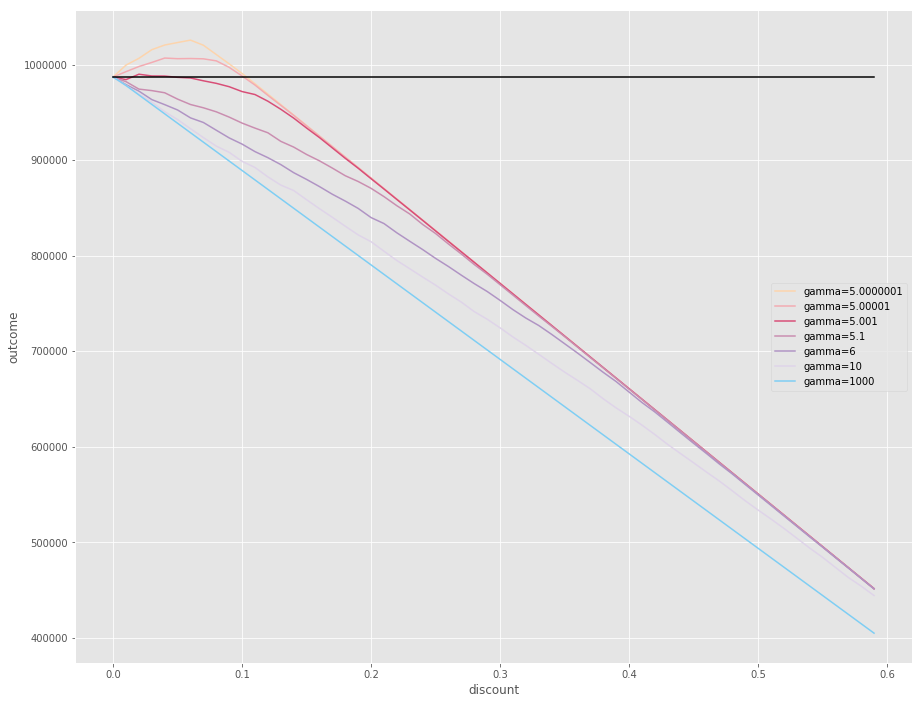

In [6]:
discount_list = [i for i in np.arange(0,0.6,0.01)]


fig,axs = plt.subplots(figsize=(15,12))
axs.plot(discount_list,[discount_revenue(df,i,5.0000001)[1] for i in discount_list],
         color=c_list[0],label="gamma=5.0000001")
axs.plot(discount_list,[discount_revenue(df,i,5.00001)[1] for i in discount_list],
         color=c_list[1],label="gamma=5.00001")
axs.plot(discount_list,[discount_revenue(df,i,5.001)[1] for i in discount_list],
         color=c_list[2],label="gamma=5.001")
axs.plot(discount_list,[discount_revenue(df,i,5.1)[1] for i in discount_list],
         color=c_list[3],label="gamma=5.1")
axs.plot(discount_list,[discount_revenue(df,i,6)[1] for i in discount_list],
         color=c_list[4],label="gamma=6")
axs.plot(discount_list,[discount_revenue(df,i,10)[1] for i in discount_list],
         color=c_list[5],label="gamma=10")
axs.plot(discount_list,[discount_revenue(df,i,1000)[1] for i in discount_list],
         color=c_list[6],label="gamma=1000")
axs.plot(discount_list, [revenue_o_discount for i in discount_list], color='black')

plt.xlabel("discount")
plt.ylabel("outcome")
plt.legend(loc="center right")
plt.show()

## Break-even Outcome Analysis

For any discount rate between 0 and 60%, there must be a break-even outcome that keeps the revenue under the discount rate same as that no discount is issued at all, which is to say, if PowerCo want to retain clients by offering discount without harming the revenue, at least the clients should be this level less to churn. 

We can plot a outcome-discount curve where all the points on the curve are break-even outcomes.

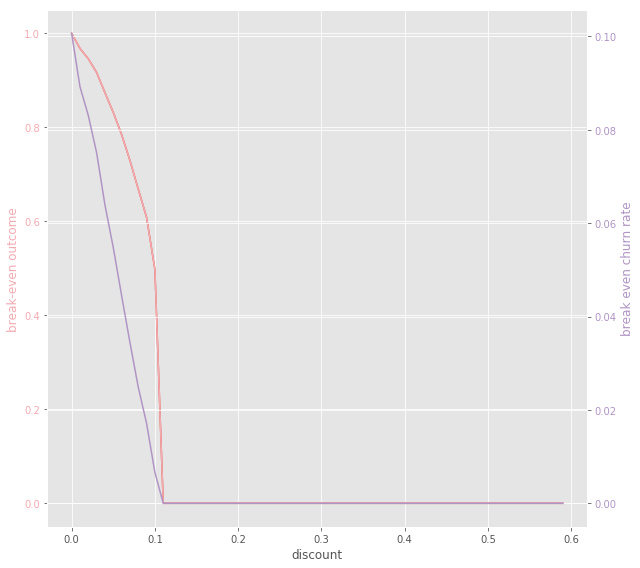

In [7]:
def find_breakeven_outcome(df,discount,start=1,end=0):
    for outcome in np.arange(start,end,-0.001):
        df["churn_discount"] = df["churn_probability"].apply(lambda x:1 if x*outcome>=threshold else 0)
        df["revenue_after_discount"] = (1-discount)*df["base_revenue"]*(1-0.919*df["churn_discount"])
        mean_churn = np.mean(df["churn_discount"])
        total_revenue = df["revenue_after_discount"].sum()
        if total_revenue-revenue_o_discount>=0.0001:
            return round(outcome,3),mean_churn
            break
        else:
            if outcome-end<0.001:              
                return 0,mean_churn
            
breakeven_list = []
mean_churn_list = []
new_start = 1
for item in discount_list:
    outcome = find_breakeven_outcome(df,item,start=new_start)[0]
    churn_rate = find_breakeven_outcome(df,item,start=new_start)[1]
    breakeven_list.append(outcome)
    mean_churn_list.append(churn_rate)
    if outcome>=0.95:
        new_start = 1
    else:
        new_start = outcome+0.05
        
fig,ax1 = plt.subplots(figsize=(9,8))
ax1.plot(discount_list,breakeven_list)

plt.xlabel("discount")
plt.ylabel("outcome")
ax1.set_xlabel('discount')
ax1.set_ylabel('break-even outcome', color='#F3ABB2')
ax1.plot(discount_list, breakeven_list, color='#F3ABB2')
ax1.tick_params(axis='y', labelcolor='#F3ABB2')

ax2 = ax1.twinx() 
ax2.set_ylabel('break even churn rate', color='#B094C4') 
ax2.plot(discount_list, mean_churn_list, color='#B094C4')
ax2.tick_params(axis='y', labelcolor='#B094C4')

plt.tight_layout()
plt.show()

From this plot we can see that if we offer discount larger than 10%, there's no chance that PowerCo could achieve a revenue that equals or exceeds that when no discount is offered. Also, to get a 10% discount successful, clients should be 50.3% less likely to churn, the total churn rate of the over 4000 clients is 0.0662%; 9.9% dicount, 49.2% less likely to churn, the total churn rate is 1.71%; etc. If we can get less than the break even churn rate of clients to churn, then we'll get retention and revenue at the same time.

In [8]:
break_even_df = pd.DataFrame(data=np.array([discount_list[:-44],breakeven_list[:-44],
                mean_churn_list[:-44]]).T,columns=["discount","break even outcome","mean churn rate"])
break_even_df

,discount,break even outcome,mean churn rate
0,0.00,0.999,0.100639
1,0.01,0.967,0.089229
2,0.02,0.945,0.083067
3,0.03,0.916,0.075080
4,0.04,0.873,0.063898
5,0.05,0.831,0.054770
6,0.06,0.784,0.044500
7,0.07,0.729,0.034459
8,0.08,0.668,0.024874
9,0.09,0.608,0.017115
